In [1]:
import pandas as pd

# Load the datasets
customers_path = '/content/Customers.csv'
transactions_path = '/content/Transactions.csv'

# Read the data into DataFrames
customers_df = pd.read_csv(customers_path)
transactions_df = pd.read_csv(transactions_path)

# Display the first few rows of each dataset and their summaries
customers_head = customers_df.head()
customers_info = customers_df.info()

transactions_head = transactions_df.head()
transactions_info = transactions_df.info()

customers_head, customers_info, transactions_head, transactions_info


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   TransactionID    1000 non-null   object 
 1   CustomerID       1000 non-null   object 
 2   ProductID        1000 non-null   object 
 3   TransactionDate  1000 non-null   object 
 4   Quantity         1000 non-null   int64  
 5   TotalValue       1000 non-null   float64
 6   Price            1000 non-null   float64
dtypes: float64(2), int64(1), object(4)
memory usage: 54.8+ KB


(  CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
 None,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  2024-04-25 07:38:55         1   
 3        T00272      C0087      P067  2024-03-26 22:55:37         2   
 4        T00363      C0070      P067  2024-03-21 15:10:10         3   
 
    TotalValue   Price  
 0      300.68  300.68  
 1      300.68  300.68  
 2      300.68  300.68  
 3      601.36  300.68  
 4      902.04  300.68  ,
 None)

In [2]:
# Merge datasets on CustomerID
merged_df = pd.merge(customers_df, transactions_df, on='CustomerID')

# Feature engineering
# Convert SignupDate and TransactionDate to datetime
merged_df['SignupDate'] = pd.to_datetime(merged_df['SignupDate'])
merged_df['TransactionDate'] = pd.to_datetime(merged_df['TransactionDate'])

# Calculate time since signup in days
merged_df['DaysSinceSignup'] = (merged_df['TransactionDate'].max() - merged_df['SignupDate']).dt.days

# Aggregate transaction data at the customer level
customer_summary = merged_df.groupby('CustomerID').agg({
    'TotalValue': 'sum',  # Total spending
    'TransactionID': 'count',  # Number of transactions
    'Price': 'mean',  # Average price per transaction
    'DaysSinceSignup': 'first',  # Days since signup
    'Region': 'first'  # Region (categorical)
}).rename(columns={
    'TotalValue': 'TotalSpending',
    'TransactionID': 'TransactionCount',
    'Price': 'AvgTransactionValue'
}).reset_index()

# Display the customer summary
customer_summary.head()


,CustomerID,TotalSpending,TransactionCount,AvgTransactionValue,DaysSinceSignup,Region
0,C0001,3354.52,5,278.334000,902,South America
1,C0002,1862.74,4,208.920000,1049,Asia
2,C0003,2725.38,4,195.707500,296,South America
3,C0004,5354.88,8,240.636250,811,South America
4,C0005,2034.24,3,291.603333,866,Asia


In [3]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# One-hot encode the Region column and standardize numerical columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), ['TotalSpending', 'TransactionCount', 'AvgTransactionValue', 'DaysSinceSignup']),
        ('cat', OneHotEncoder(), ['Region'])
    ],
    remainder='drop'
)

# Apply preprocessing
processed_data = preprocessor.fit_transform(customer_summary)

# Convert preprocessed data back to a DataFrame for inspection
processed_columns = (
    ['TotalSpending', 'TransactionCount', 'AvgTransactionValue', 'DaysSinceSignup'] +
    list(preprocessor.named_transformers_['cat'].get_feature_names_out(['Region']))
)
processed_df = pd.DataFrame(processed_data, columns=processed_columns)

processed_df.head()


,TotalSpending,TransactionCount,AvgTransactionValue,DaysSinceSignup,Region_Asia,Region_Europe,Region_North America,Region_South America
0,-0.061701,-0.011458,0.094670,1.148752,0.0,0.0,0.0,1.0
1,-0.877744,-0.467494,-0.904016,1.600431,1.0,0.0,0.0,0.0
2,-0.405857,-0.467494,-1.094109,-0.713270,0.0,0.0,0.0,1.0
3,1.032547,1.356650,-0.447702,0.869141,0.0,0.0,0.0,1.0
4,-0.783929,-0.923530,0.285581,1.038137,1.0,0.0,0.0,0.0


In [4]:
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import numpy as np

# Test different numbers of clusters (2 to 10)
results = []
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(processed_data)

    # Compute metrics
    db_index = davies_bouldin_score(processed_data, labels)
    silhouette_avg = silhouette_score(processed_data, labels)

    # Store the results
    results.append((n_clusters, db_index, silhouette_avg))

# Convert results to a DataFrame for easy visualization
results_df = pd.DataFrame(results, columns=['NumClusters', 'DaviesBouldinIndex', 'SilhouetteScore'])

results_df.sort_values(by='DaviesBouldinIndex')


,NumClusters,DaviesBouldinIndex,SilhouetteScore
5,7,1.365216,0.199833
4,6,1.385973,0.195352
6,8,1.415236,0.190195
3,5,1.424933,0.199528
7,9,1.458629,0.175440
8,10,1.483709,0.167397
2,4,1.529575,0.193774
1,3,1.599039,0.199394
0,2,1.615956,0.218592


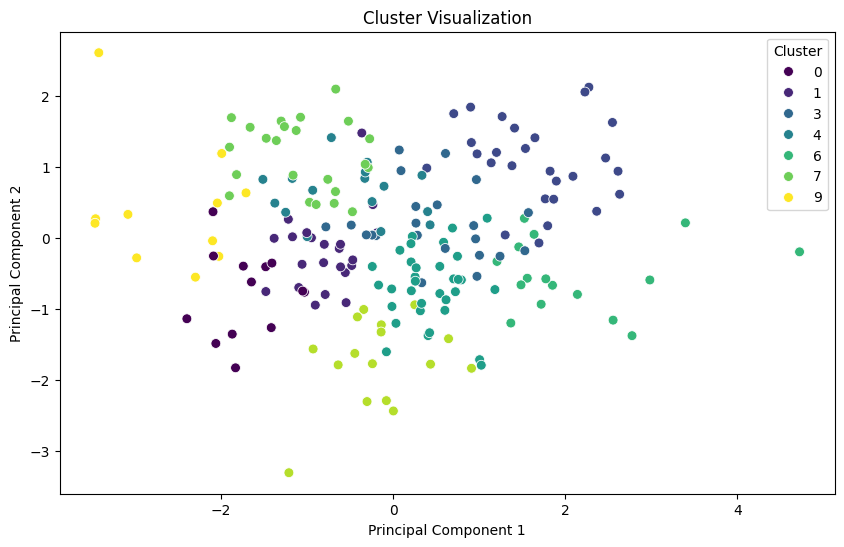

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# Use PCA to reduce dimensionality for visualization (2D plot)
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(processed_data)

# Create a DataFrame for visualization
visualization_data = pd.DataFrame(reduced_data, columns=['PCA1', 'PCA2'])
visualization_data['Cluster'] = labels

# Plot the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(
    x='PCA1',
    y='PCA2',
    hue='Cluster',
    palette='viridis',
    data=visualization_data,
    s=50
)
plt.title('Cluster Visualization')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Cluster')
plt.show()
